In [1]:
import os
from pathlib import Path
from operator import itemgetter

import scanpy as sc
import numpy as np
import pandas as pd

import scSLAT
from scSLAT.model import run_SLAT_multi,load_anndatas, Cal_Spatial_Net, run_SLAT, scanpy_workflow, spatial_match
from scSLAT.viz import match_3D_multi, hist, Sankey, match_3D_celltype, Sankey
from scSLAT.metrics import region_statistics

In [2]:
sc.set_figure_params(dpi=150, dpi_save=150)

In [20]:
adata1 = sc.read_h5ad('../../../spatialGLUE/data/stereo_seq/counts/E11.5/count_E11.5_E1S2.MOSTA.h5ad')
adata2 = sc.read_h5ad('../../../spatialGLUE/data/stereo_seq/counts/E12.5/count_E12.5_E1S4.MOSTA.h5ad')
print(f"adata1: {adata1.shape[0]} cells, adata2: {adata2.shape[0]} cells")

adata1: 30756 cells, adata2: 55295 cells


In [21]:
adata1 = sc.pp.subsample(adata1, n_obs=10000, copy=True)
adata2 = sc.pp.subsample(adata2, n_obs=10001, copy=True)

In [28]:
adata1.write_h5ad('./adata1_E115_E1S2.h5ad')
adata2.write_h5ad('./adata2_E125_E1S4.h5ad')

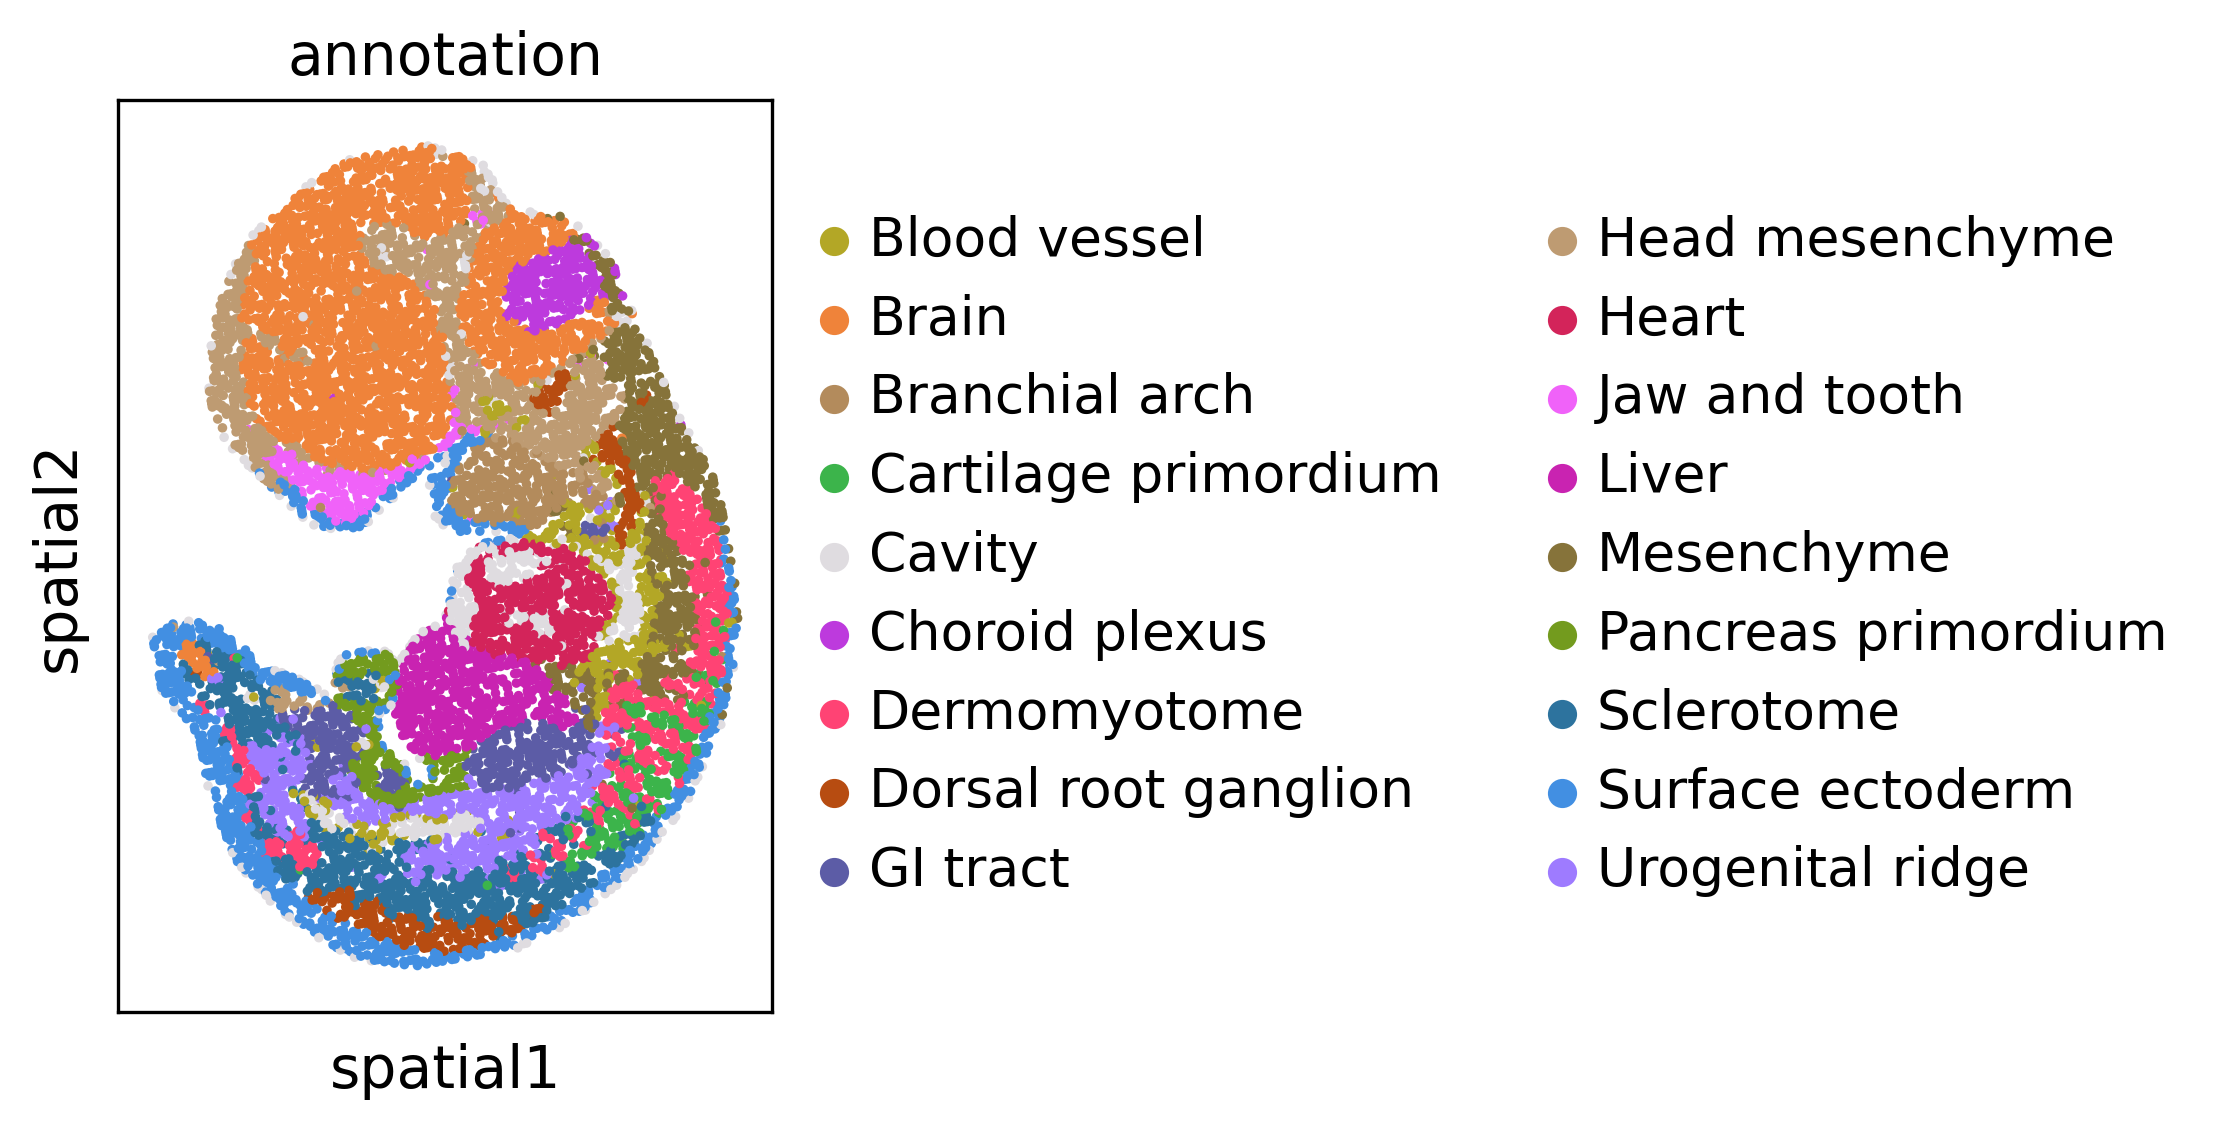

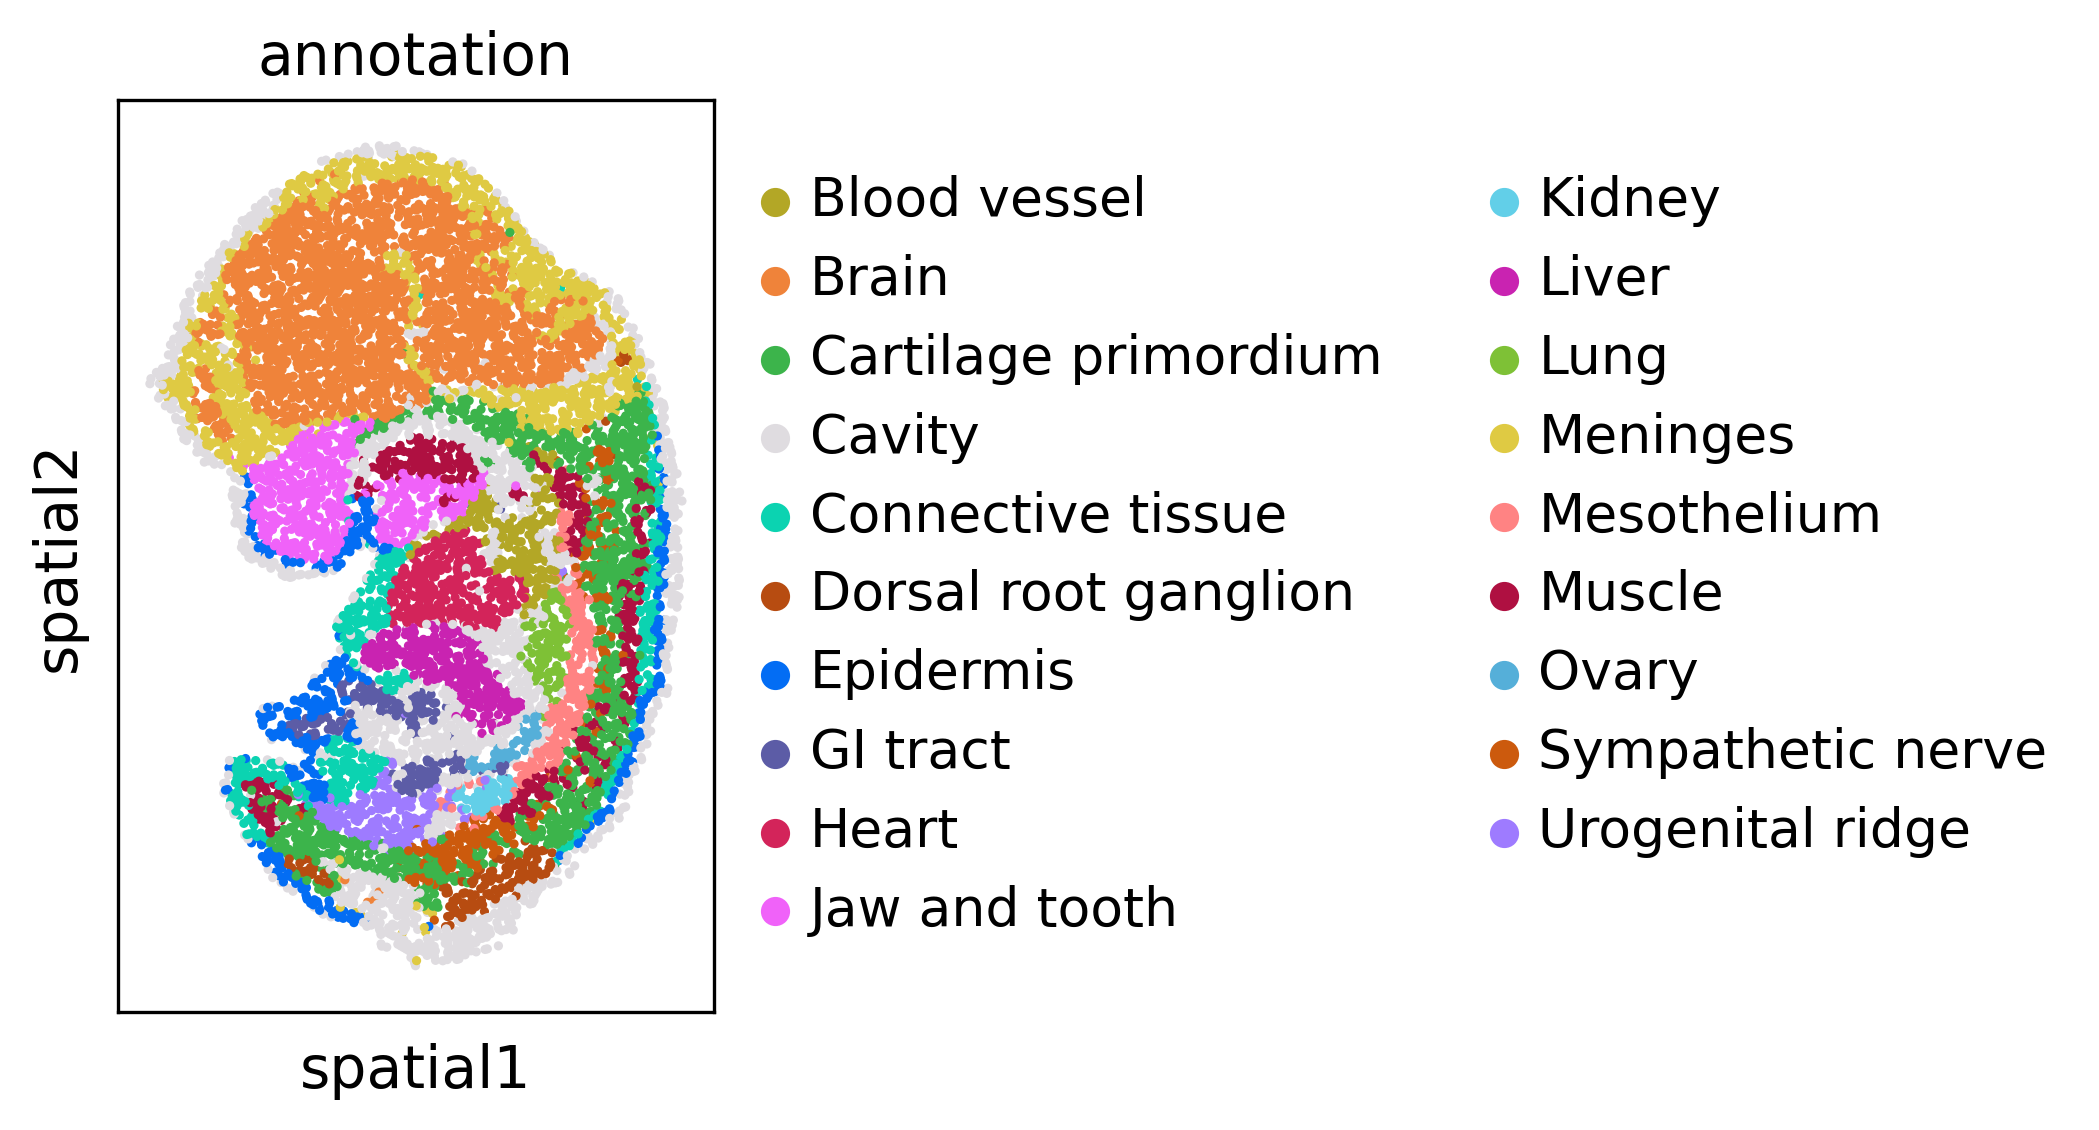

In [34]:
sc.pl.spatial(adata1, color='annotation', spot_size=3)
sc.pl.spatial(adata2, color='annotation', spot_size=4)

In [22]:
Cal_Spatial_Net(adata1, k_cutoff=20, model='KNN')
Cal_Spatial_Net(adata2, k_cutoff=20, model='KNN')
edges, features = load_anndatas([adata1, adata2], feature='DPCA', check_order=False)

Calculating spatial neighbor graph ...
The graph contains 218056 edges, 10000 cells.
21.8056 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 219239 edges, 10001 cells.
21.921707829217077 neighbors per cell on average.
Use DPCA feature to format graph


/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)
/rd2/user/xiacr/SLAT/conda/lib/python3.

Warning! Dual PCA is using GPU, which may lead to OUT OF GPU MEMORY in big dataset!


In [23]:
embd0, embd1, time = run_SLAT(features, edges, LGCN_layer=5)

Choose GPU:3 as device
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
Training model time: 1.65


In [24]:
best, index, distance = spatial_match([embd0, embd1], reorder=False, adatas=[adata1,adata2])

In [25]:
adata1_df = pd.DataFrame({'index':range(embd0.shape[0]),
                          'x': adata1.obsm['spatial'][:,0],
                          'y': adata1.obsm['spatial'][:,1],
                          'celltype':adata1.obs['annotation']})
adata2_df = pd.DataFrame({'index':range(embd1.shape[0]),
                          'x': adata2.obsm['spatial'][:,0],
                          'y': adata2.obsm['spatial'][:,1],
                          'celltype':adata2.obs['annotation']})
matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]
region_statistics(best_match,start=0.5,number_of_interval=10)

0.500~0.550        23          0.230%
0.550~0.600        81          0.810%
0.600~0.650       193          1.930%
0.650~0.700       535          5.349%
0.700~0.750      1103         11.029%
0.750~0.800      1807         18.068%
0.800~0.850      2209         22.088%
0.850~0.900      1962         19.618%
0.900~0.950      1546         15.458%
0.950~1.000       539          5.389%


/rd2/user/xiacr/SLAT/scSLAT/viz/multi_dataset.py:204: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.celltypes = set(self.dataset_A[meta].append(self.dataset_B[meta]))


dataset1: 18 cell types; dataset2: 19 cell types; 
                    Total :27 celltypes; Overlap: 10 cell types 
                    Not overlap :[['Head mesenchyme', 'Branchial arch', 'Surface ectoderm', 'Dermomyotome', 'Sclerotome', 'Pancreas primordium', 'Choroid plexus', 'Mesenchyme', 'Lung', 'Muscle', 'Sympathetic nerve', 'Mesothelium', 'Epidermis', 'Ovary', 'Kidney', 'Connective tissue', 'Meninges']]
Subsample 300 cell pairs from 10001


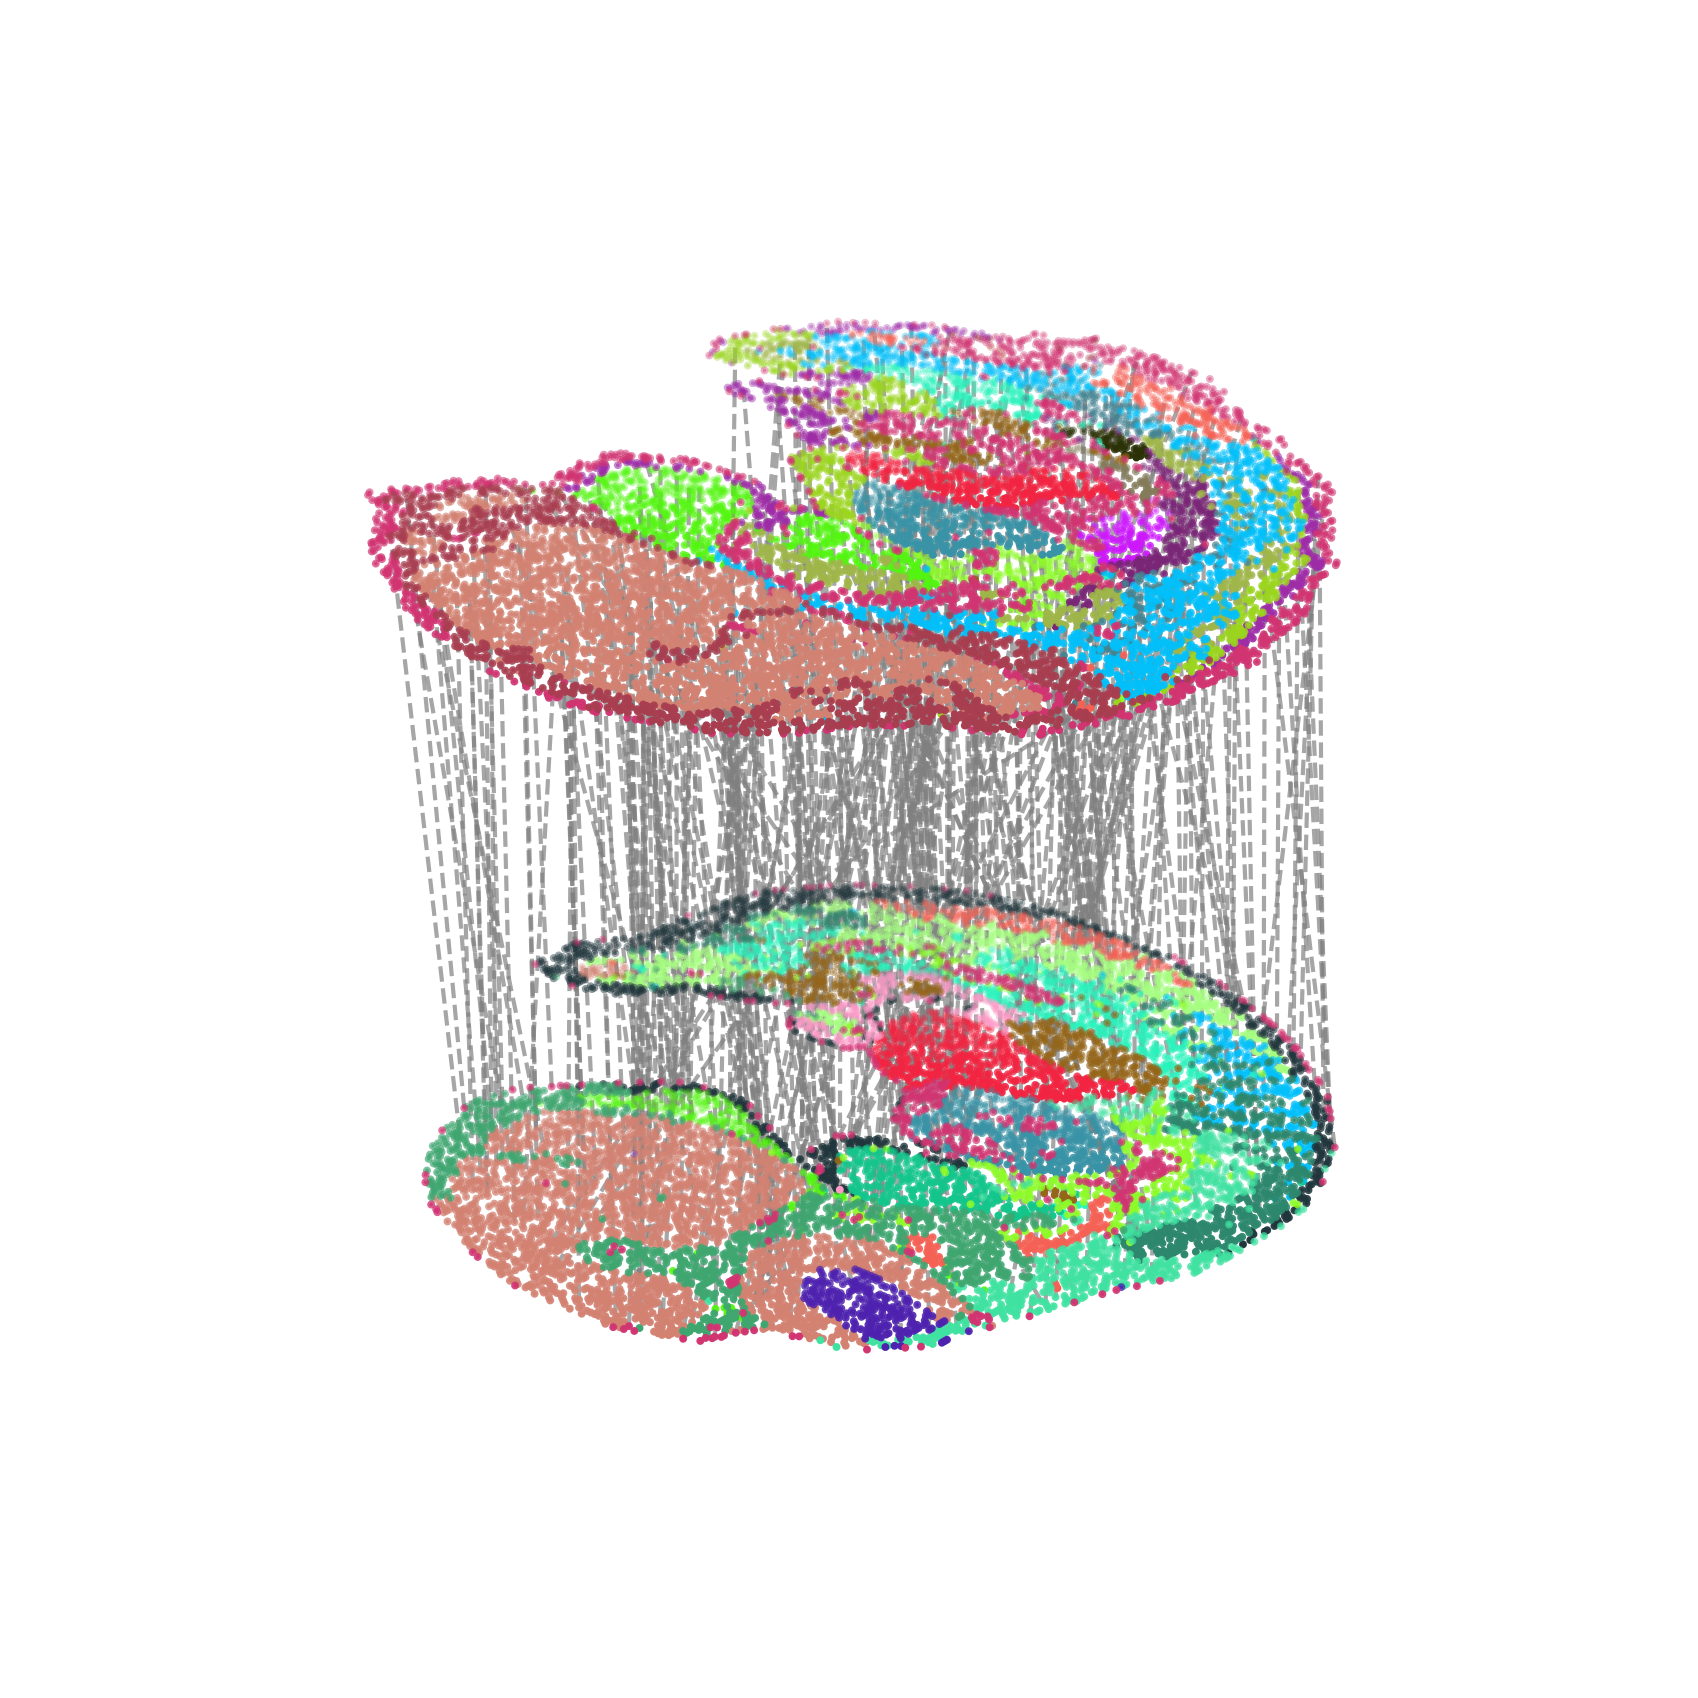

In [26]:
multi_align = match_3D_multi(adata1_df, adata2_df,matching,meta='celltype',
                             scale_coordinate=True,subsample_size=300,exchange_xy=False)

multi_align.draw_3D(size= [7, 8],line_width =1,point_size=[0.8,0.8], hide_axis=True,show_error=False)

/rd2/user/xiacr/SLAT/scSLAT/viz/multi_dataset.py:204: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.celltypes = set(self.dataset_A[meta].append(self.dataset_B[meta]))


dataset1: 18 cell types; dataset2: 19 cell types; 
                    Total :27 celltypes; Overlap: 10 cell types 
                    Not overlap :[['Head mesenchyme', 'Branchial arch', 'Surface ectoderm', 'Dermomyotome', 'Sclerotome', 'Pancreas primordium', 'Choroid plexus', 'Mesenchyme', 'Lung', 'Muscle', 'Sympathetic nerve', 'Mesothelium', 'Epidermis', 'Ovary', 'Kidney', 'Connective tissue', 'Meninges']]
Subsample 10000 cell pairs from 10001


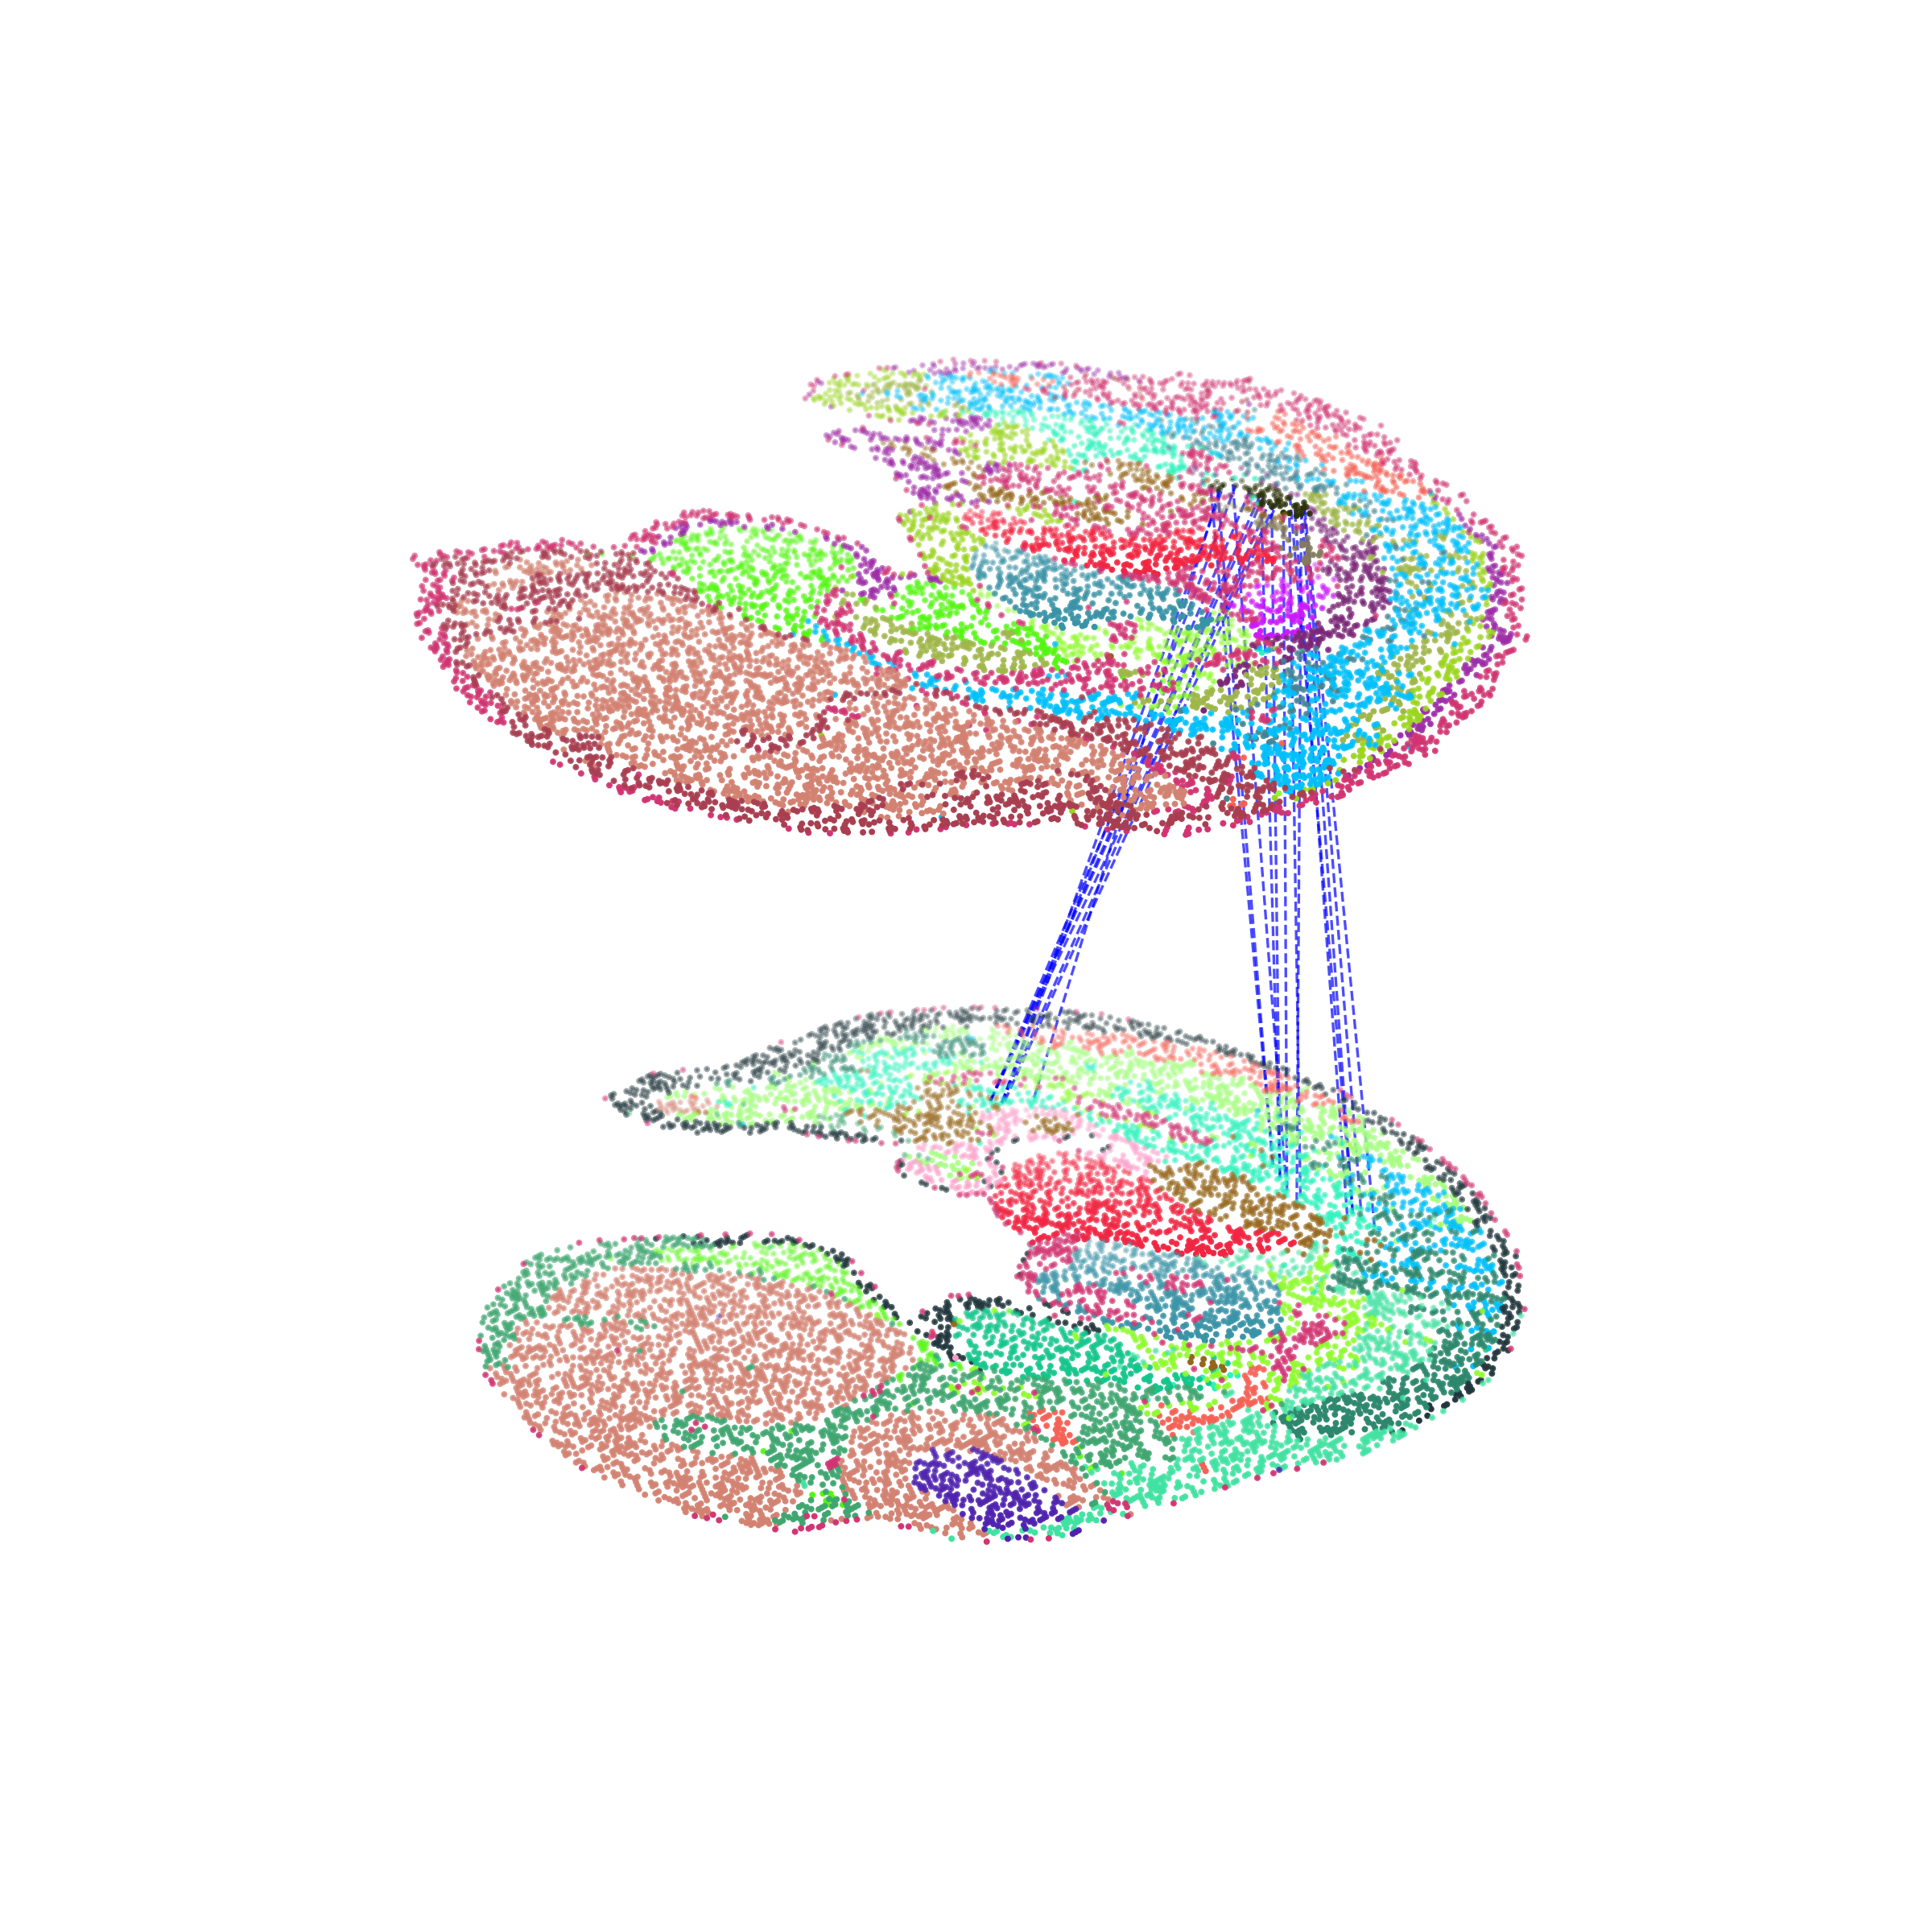

In [36]:
test = match_3D_celltype(adata1_df, adata2_df, matching, meta='celltype', highlight_celltype = [['Urogenital ridge'],['Kidney']],subsample_size=10000, highlight_line = ['blue'],scale_coordinate = True )
test.draw_3D(size= [10, 12],line_width =0.8,point_size=[0.8,0.8], hide_axis=True)

In [42]:
adata2_df['target_celltype'] = adata1_df.iloc[matching[1,:],:]['celltype'].to_list()
matching_table = adata2_df.groupby(['celltype','target_celltype']).size().unstack(fill_value=0)

/rd2/user/xiacr/SLAT/scSLAT/viz/multi_dataset.py:204: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



dataset1: 18 cell types; dataset2: 19 cell types; 
                    Total :27 celltypes; Overlap: 10 cell types 
                    Not overlap :[['Head mesenchyme', 'Branchial arch', 'Surface ectoderm', 'Dermomyotome', 'Sclerotome', 'Pancreas primordium', 'Choroid plexus', 'Mesenchyme', 'Lung', 'Muscle', 'Sympathetic nerve', 'Mesothelium', 'Epidermis', 'Ovary', 'Kidney', 'Connective tissue', 'Meninges']]
Subsample 10000 cell pairs from 10001


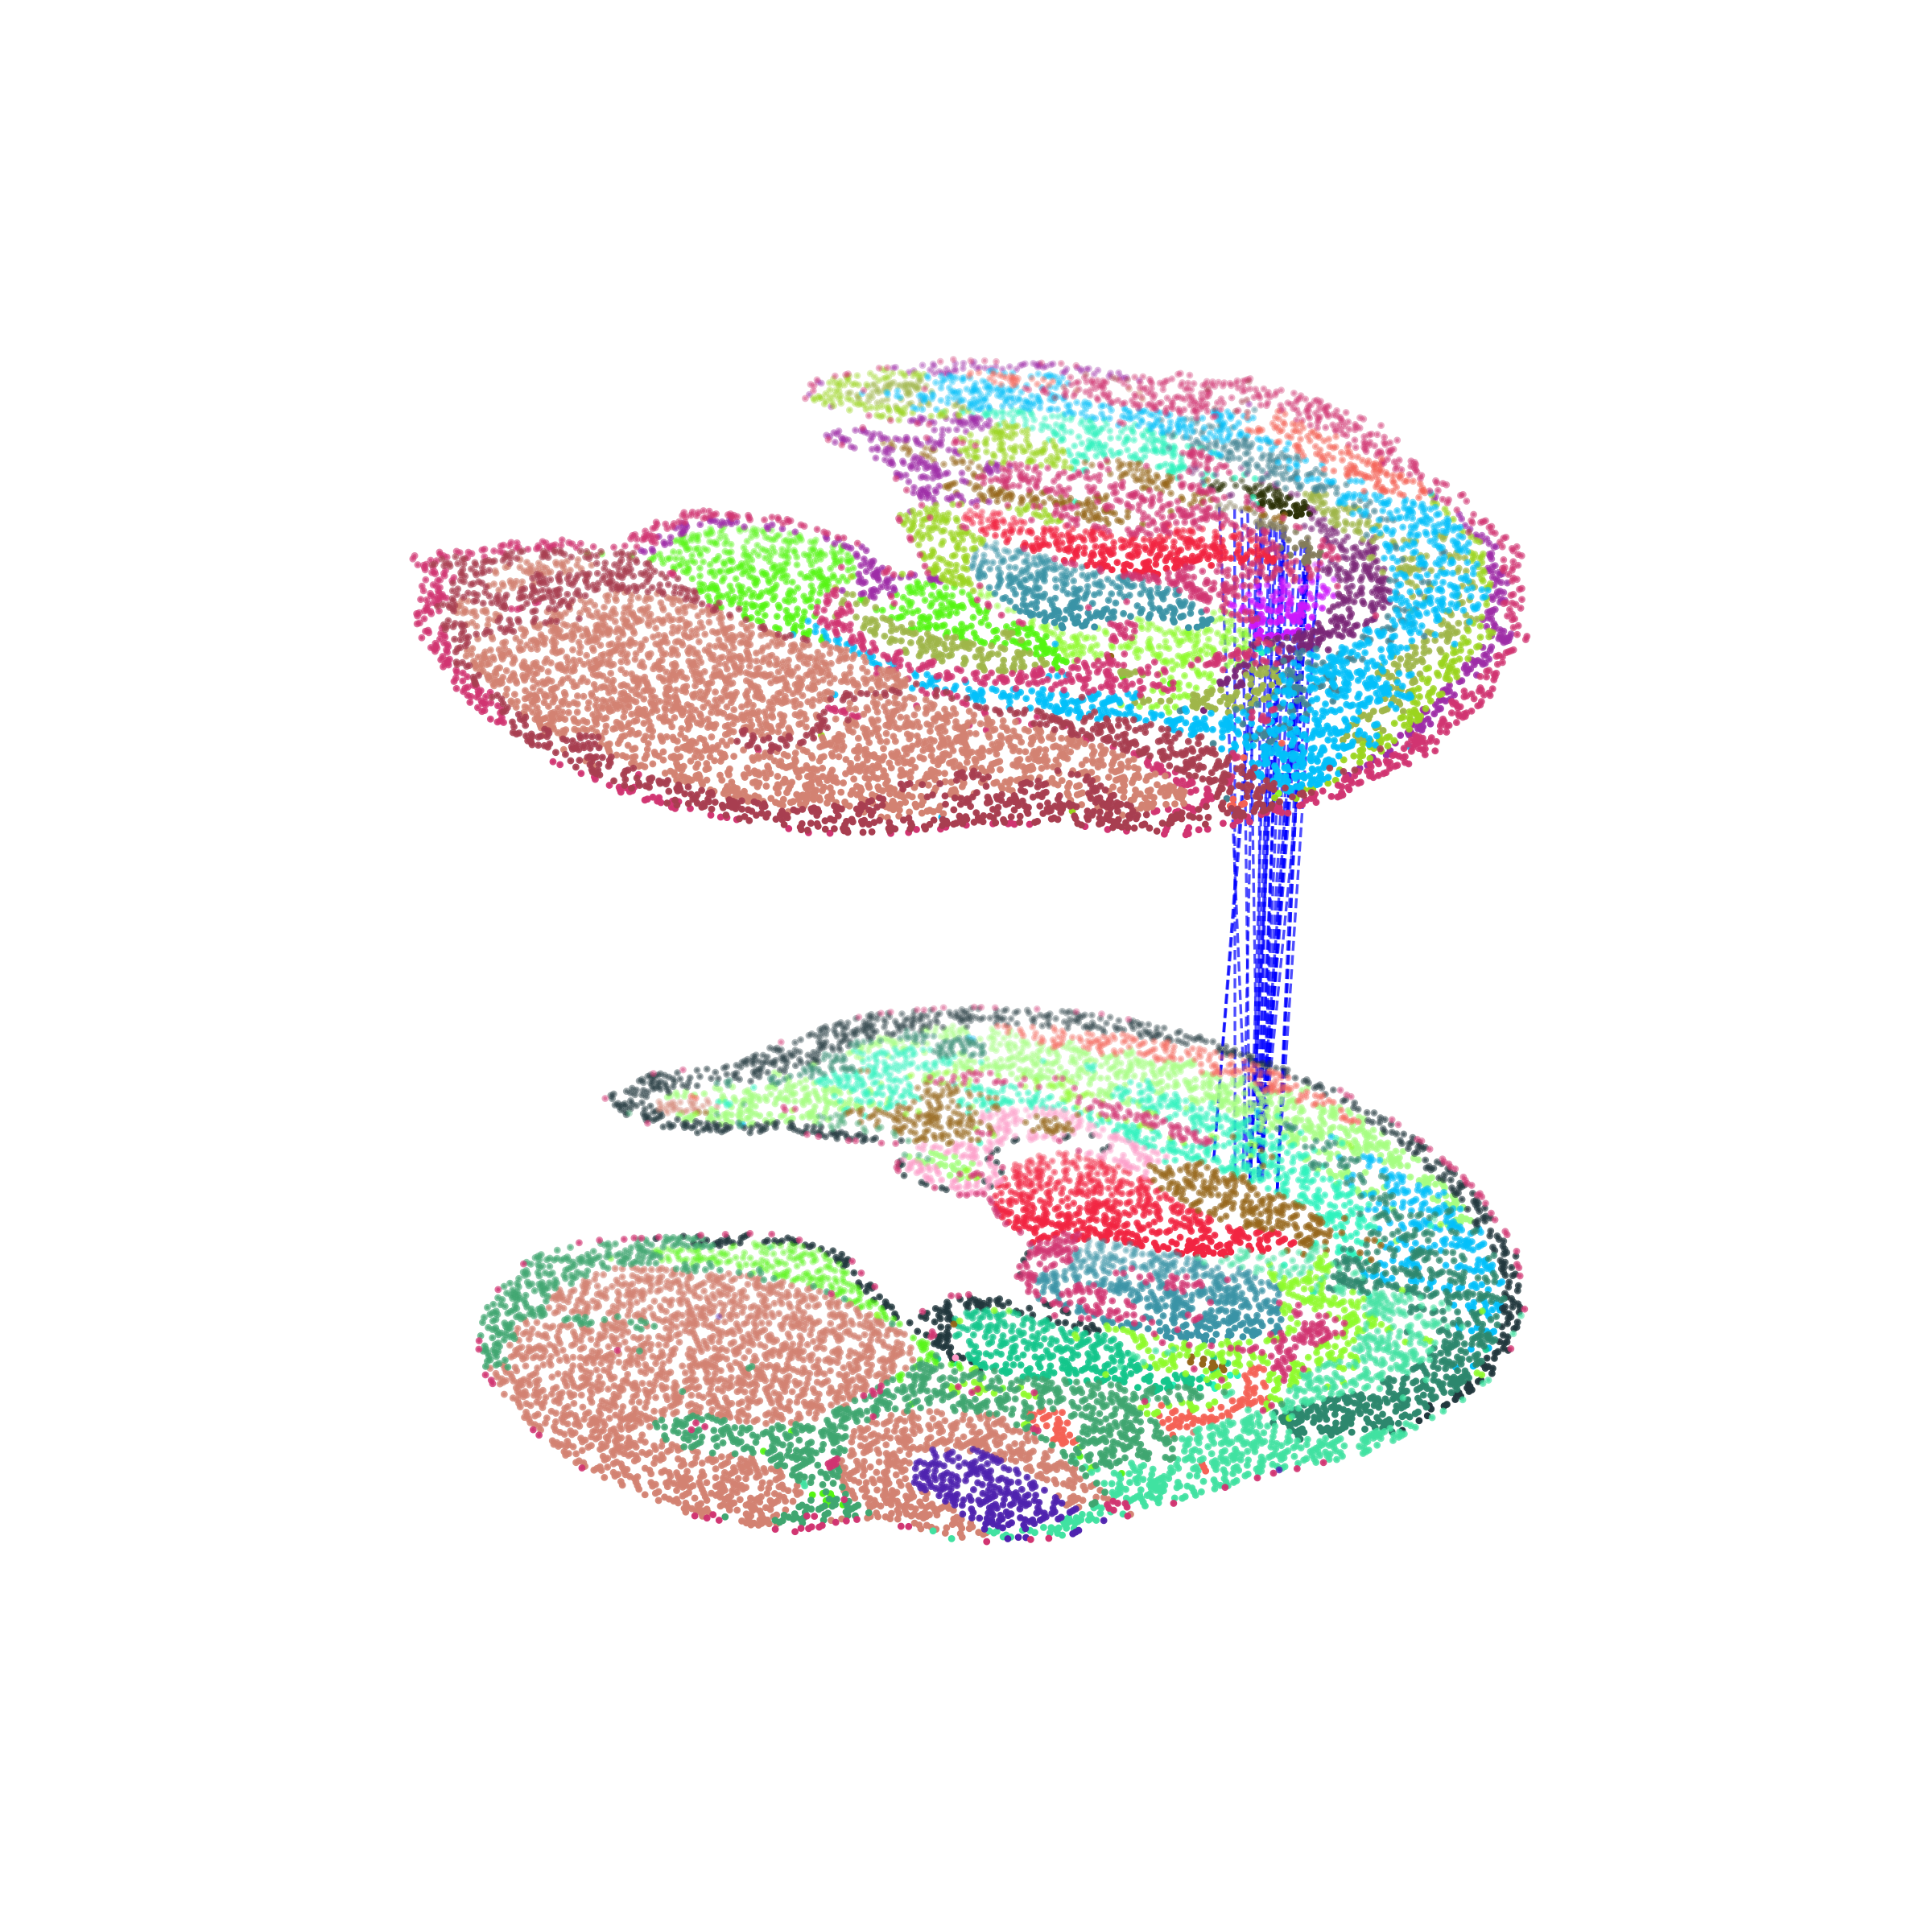

In [41]:
test = match_3D_celltype(adata1_df, adata2_df, matching, meta='celltype', highlight_celltype = [['Urogenital ridge'],['Ovary']],subsample_size=10000, highlight_line = ['blue'],scale_coordinate = True)
test.draw_3D(size= [10, 12],line_width =0.8,point_size=[1.2,1.2], hide_axis=True)